# Subgraphs

Compiling a langgraph instance turns it into a regular langchain runnable. This can be used as a node in any other graph.

Creating subgraphs lets you build things like [multi-agent teams](./multi_agent/hierarchical_agent_teams.ipynb), where each team can track its own separate state.

Below is a simple (somewhat contrived) example of a graph with a node that itself is a graph. The subgraph will contain a simple tool-less "agent" that generates a response then critiques itself 3 times in a loop.

In [ ]:
%pip install -U langgraph langchain_anthropic

In [ ]:
import getpass
import os

os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LANGCHAIN_API_KEY")
os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("ANTHROPIC_API_KEY")

## Subgraph

Our toy subgraph will be a simple loop that generates a joke then critiques itself.

In [42]:
import operator
from typing import Annotated, List, TypedDict

from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph

llm = ChatAnthropic(temperature=0, model_name="claude-3-opus-20240229")
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You're the jokester. Respond with a joke, the best joke ever fashioned.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ],
)


critic_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You're the standup critic. Roast the bad joke."),
        MessagesPlaceholder(variable_name="messages"),
    ],
)


def update(out):
    return {"messages": [out]}


def replace_role(out):
    return {"messages": [("user", out.content)]}

In [ ]:
## Build the subgraph


class SubGraphState(TypedDict):
    messages: Annotated[List, operator.add]


builder = StateGraph(SubGraphState)
builder.add_node("tell_joke", prompt | llm | update)
builder.add_node("critique", critic_prompt | llm | replace_role)


def route(state):
    return END if len(state["messages"]) >= 3 else "critique"


builder.add_conditional_edges("tell_joke", route)
builder.add_edge("critique", "tell_joke")
builder.set_entry_point("tell_joke")
joke_graph = builder.compile()

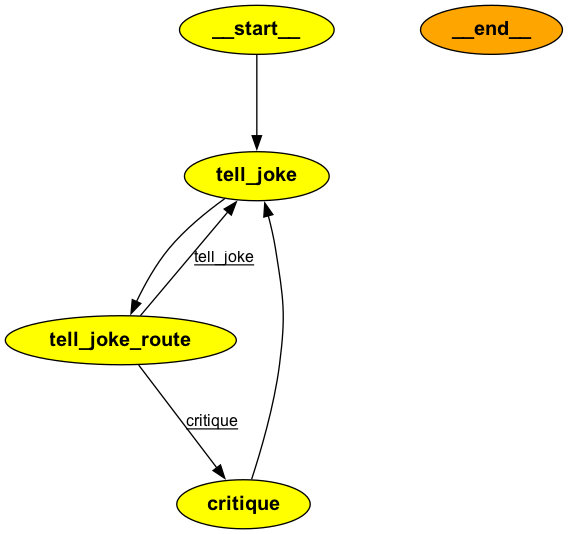

In [43]:
from IPython.display import Image

Image(joke_graph.get_graph().draw_png())

In [22]:
for step in joke_graph.stream({"messages": [("user", "Tell a joke about pasta")]}):
    print(step)

{'tell_joke': {'messages': [AIMessage(content='Sure, here\'s a joke about pasta:\n\nWhat do you call a fake noodle? An impasta!\n\nThis joke plays on the similarity between the words "imposter" (someone pretending to be someone else) and "pasta." The pun suggests that a fake noodle would be called an "impasta," combining the words "imposter" and "pasta" for humorous effect.')]}}
{'critique': {'messages': [('user', "\n\nWhile this joke relies on a simple pun and isn't very sophisticated, puns are a common form of humor. The joke is short, easy to remember, and kid-friendly. Some might find it mildly amusing, while others may groan at the corny wordplay.\n\nOverall, it's an inoffensive joke that plays it safe, but isn't likely to get big laughs from most audiences. The pasta pun is a bit obvious and cliché. For a stronger joke, it would help to have some more original wordplay or a clever twist that goes beyond just a simple pun.")]}}
{'tell_joke': {'messages': [AIMessage(content='You ma

## Main Graph

The main graph is just a router that either sends the message to the joke graph or responds directly.

In [38]:
class AssistantState(TypedDict):
    conversation: Annotated[List, operator.add]


assistant_llm = ChatAnthropic(temperature=0, model_name="claude-3-opus-20240229")
assistant_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant"),
        MessagesPlaceholder(variable_name="conversation"),
    ]
)


def add_to_conversation(message):
    return {"conversation": [message]}


main_builder = StateGraph(AssistantState)
main_builder.add_node(
    "assistant", assistant_prompt | assistant_llm | add_to_conversation
)


def get_user_message(state: AssistantState):
    last_message = state["conversation"][-1]
    # Convert to sub-graph state
    return {"messages": [last_message]}


def get_joke(state: SubGraphState):
    final_joke = state["messages"][-1]
    return {"conversation": [final_joke]}


main_builder.add_node("joke_graph", get_user_message | joke_graph | get_joke)


def route(state: AssistantState):
    if "joke" in state["conversation"][-1][-1]:
        return "joke_graph"
    return "assistant"


main_builder.set_conditional_entry_point(
    route,
)
main_builder.set_finish_point("assistant")
main_builder.set_finish_point("joke_graph")
graph = main_builder.compile()

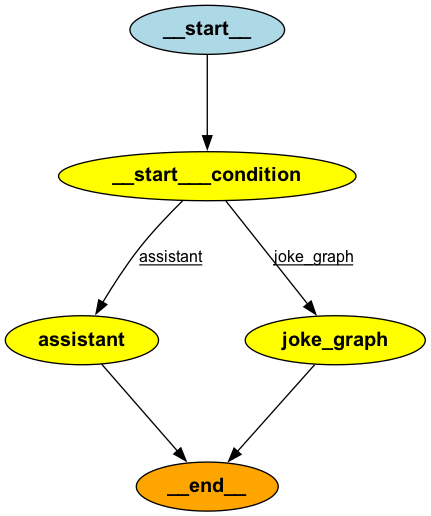

In [39]:
Image(graph.get_graph().draw_png())

In [40]:
for step in graph.stream({"conversation": [("user", "Tell a joke about pasta")]}):
    print(step)

{'joke_graph': {'conversation': [AIMessage(content="*chuckles* Oh boy, looks like we've got a real fusilli one over here! I bet you've got a ton of pasta puns all penne'd up. But hey, orzo you thought - I'm a bit of an impasta myself! Though I am trying to diversify my joke portfolio... I've been told putting all my eggs in one basket is not a very gnocchi idea.\n\nBut hey, keep the cheesy jokes coming - I promise I won't get too tagliatelle the truth if they fall flat. After all, laughter is good for your elbows... or wait, is that the other body part? Ah well, I'm sure we'll both feel tortellini awesome after a good laugh either way!")]}}
{'__end__': {'conversation': [('user', 'Tell a joke about pasta'), AIMessage(content="*chuckles* Oh boy, looks like we've got a real fusilli one over here! I bet you've got a ton of pasta puns all penne'd up. But hey, orzo you thought - I'm a bit of an impasta myself! Though I am trying to diversify my joke portfolio... I've been told putting all my

In [44]:
for step in graph.stream({"conversation": [("user", "How YOU doin?")]}):
    print(step)

{'assistant': {'conversation': [AIMessage(content="I'm doing well, thanks for asking! As an AI assistant, I don't have feelings per se, but I'm functioning properly and ready to help out however I can. How are you doing today? Let me know if there are any questions I can assist with.")]}}
{'__end__': {'conversation': [('user', 'How YOU doin?'), AIMessage(content="I'm doing well, thanks for asking! As an AI assistant, I don't have feelings per se, but I'm functioning properly and ready to help out however I can. How are you doing today? Let me know if there are any questions I can assist with.")]}}
